# The German Credit XGBoost model

### The Data

The German Credit data set is a publically available data set downloaded from the UCI Machine Learning Repository. The data contains data on 20 variables and the classification whether an applicant is considered a Good or a Bad credit risk for 1000 loan applicants.

#### [Data Source](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data))
- Professor Dr. Hans Hofmann  
- Institut f"ur Statistik und "Okonometrie  
- Universit"at Hamburg  
- FB Wirtschaftswissenschaften  
- Von-Melle-Park 5    
- 2000 Hamburg 13

#### Benchmark
![Credit Risk Classification: Faster Machine Learning with Intel Optimized Packages](https://i.imgur.com/nL1l7WI.png)

according to [1] the best model is Random Forest with balanced feature selection data. it's has Accuracy 82%, Precision 84%, Recall 82% and F1-Score 81%. 

<br>


The goal of this kernel is to beat The benchmark with  :
- Convert dataset to Machine Learning friendly (Feature Engginering)
- Develop XGBoost model to predict whether a loan is a good or bad risk.
- Find the Best parameter for XGBoost Model (Hyperparameter Tunning)
- Beat the Benchmark

### Import Library

In [1]:
#Importing necessary packages in Python 
%matplotlib inline 
import matplotlib.pyplot as plt 

import numpy as np ; np.random.seed(sum(map(ord, "aesthetics")))
import pandas as pd

from sklearn.datasets import make_classification 
from sklearn.model_selection import learning_curve
#from sklearn.cross_validation import train_test_split 
#from sklearn.grid_search import GridSearchCV
#from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import ShuffleSplit,train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler

import seaborn 
seaborn.set_context('notebook') 
seaborn.set_style(style='darkgrid')

from pprint import pprint 
 


### Evaluation Function


In [2]:
# Function for evaluation reports
def get_eval1(clf, X,y):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X, y, cv=2, scoring='accuracy')
    scores2 = cross_val_score(clf, X, y, cv=2, scoring='precision')
    scores3 = cross_val_score(clf, X, y, cv=2, scoring='recall')
    scores4 = cross_val_score(clf, X, y, cv=2, scoring='roc_auc')
    
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std()))
    
    return 

def get_eval2(clf, X_train, y_train,X_test, y_test):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X_test, y_test, cv=2, scoring='accuracy')
    scores2 = cross_val_score(clf, X_test, y_test, cv=2, scoring='precision')
    scores3 = cross_val_score(clf, X_test, y_test, cv=2, scoring='recall')
    scores4 = cross_val_score(clf, X_test, y_test, cv=2, scoring='roc_auc')
    
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std()))
    
    return  
  
# Function to get roc curve
def get_roc (y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="upper left")
    plt.show()
    return


### XGBoost Model

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import xgboost as xgb
from xgboost import XGBClassifier
#print('XGBoost v',xgb.__version__)

# fit, train and cross validate Decision Tree with training and test data 
def xgbclf(params, X_train, y_train,X_test, y_test):
  
    eval_set=[(X_train, y_train), (X_test, y_test)]
    
    model = XGBClassifier(**params).\
      fit(X_train, y_train, eval_set=eval_set, \
                  eval_metric='auc', early_stopping_rounds = 100, verbose=100)
        
    #print(model.best_ntree_limit)

    model.set_params(**{'n_estimators': model.best_ntree_limit})
    model.fit(X_train, y_train)
    #print(model,'\n')
    
    # Predict target variables y for test data
    y_pred = model.predict(X_test, ntree_limit=model.best_ntree_limit) #model.best_iteration
    #print(y_pred)
   
    # Get Cross Validation and Confusion matrix
    #get_eval(model, X_train, y_train)
    #get_eval2(model, X_train, y_train,X_test, y_test)
    
    # Create and print confusion matrix    
    abclf_cm = confusion_matrix(y_test,y_pred)
    print(abclf_cm)
    
    #y_pred = model.predict(X_test)
    print (classification_report(y_test,y_pred) )
    print ('\n')
    print ("Model Final Generalization Accuracy: %.6f" %accuracy_score(y_test,y_pred) )
    
    # Predict probabilities target variables y for test data
    y_pred_proba = model.predict_proba(X_test, ntree_limit=model.best_ntree_limit)[:,1] #model.best_iteration
    get_roc (y_test,y_pred_proba)
    return model

def plot_featureImportance(model, keys):
  importances = model.feature_importances_

  importance_frame = pd.DataFrame({'Importance': list(importances), 'Feature': list(keys)})
  importance_frame.sort_values(by = 'Importance', inplace = True)
  importance_frame.tail(10).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

### Preprocess
- Importing Dataset
- StandardScaler
- Encoding Categorical Feature
- Concate Transformed Dataset
- Split Training Dataset
- XGBoost  1a: Unbalance Dataset (Base Model: ROC_AUC:0.74)
- XGBoost  1b: Unbalance Dataset (ROC_AUC:0.79)

### Import Dataset

OK let's get started. We'll download the data from the UCI website.

In [4]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']

data = pd.read_csv(url, names = names, delimiter=' ')
print(data.shape)
print (data.columns)
data.head(10)

(1000, 21)
Index(['existingchecking', 'duration', 'credithistory', 'purpose',
       'creditamount', 'savings', 'employmentsince', 'installmentrate',
       'statussex', 'otherdebtors', 'residencesince', 'property', 'age',
       'otherinstallmentplans', 'housing', 'existingcredits', 'job',
       'peopleliable', 'telephone', 'foreignworker', 'classification'],
      dtype='object')


,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,...,A122,53,A143,A152,1,A173,1,A191,A201,1
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,1
8,A14,12,A32,A43,3059,A64,A74,2,A91,A101,...,A121,61,A143,A152,1,A172,1,A191,A201,1
9,A12,30,A34,A40,5234,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,2


In [5]:
# Binarize the y output for easier use of e.g. ROC curves -> 0 = 'bad' credit; 1 = 'good' credit
data.classification.replace([1,2], [1,0], inplace=True)
# Print number of 'good' credits (should be 700) and 'bad credits (should be 300)
data.classification.value_counts()

1    700
0    300
Name: classification, dtype: int64

### StandardScaler

In [6]:
#numerical variables labels
numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'peopleliable', 'classification']

# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(data[numvars].drop(['classification'], axis=1)))

### Encoding Categorical Feature

Labelencoding to transform categorical to numerical, Enables better Visualization than one hot encoding

In [7]:
from collections import defaultdict

#categorical variables labels
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 
           'telephone', 'foreignworker']

d = defaultdict(LabelEncoder)

# Encoding the variable
lecatdata = data[catvars].apply(lambda x: d[x.name].fit_transform(x))

# print transformations
for x in range(len(catvars)):
    print(catvars[x],": ", data[catvars[x]].unique())
    print(catvars[x],": ", lecatdata[catvars[x]].unique())

#One hot encoding, create dummy variables for every category of every categorical variable
dummyvars = pd.get_dummies(data[catvars])

existingchecking :  ['A11' 'A12' 'A14' 'A13']
existingchecking :  [0 1 3 2]
credithistory :  ['A34' 'A32' 'A33' 'A30' 'A31']
credithistory :  [4 2 3 0 1]
purpose :  ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']
purpose :  [4 7 3 0 1 9 5 6 2 8]
savings :  ['A65' 'A61' 'A63' 'A64' 'A62']
savings :  [4 0 2 3 1]
employmentsince :  ['A75' 'A73' 'A74' 'A71' 'A72']
employmentsince :  [4 2 3 0 1]
statussex :  ['A93' 'A92' 'A91' 'A94']
statussex :  [2 1 0 3]
otherdebtors :  ['A101' 'A103' 'A102']
otherdebtors :  [0 2 1]
property :  ['A121' 'A122' 'A124' 'A123']
property :  [0 1 3 2]
otherinstallmentplans :  ['A143' 'A141' 'A142']
otherinstallmentplans :  [2 0 1]
housing :  ['A152' 'A153' 'A151']
housing :  [1 2 0]
job :  ['A173' 'A172' 'A174' 'A171']
job :  [2 1 3 0]
telephone :  ['A192' 'A191']
telephone :  [1 0]
foreignworker :  ['A201' 'A202']
foreignworker :  [0 1]


### Concate Transformed Dataset
append the dummy variable of the initial numerical variables numvars# append 

In [8]:
data_clean = pd.concat([data[numvars], dummyvars], axis = 1)

print(data_clean.shape)

(1000, 62)


In [47]:
y_clean

0      1
1      0
2      1
3      1
4      0
      ..
995    1
996    1
997    1
998    0
999    1
Name: classification, Length: 1000, dtype: int64

### Split Training Dataset

In [19]:
# Unscaled, unnormalized data
X_clean = data_clean.drop('classification', axis=1)
y_clean = data_clean['classification']
# X,y = datasets.make_circles(n_samples= 10**4, noise = 0.4, factor =10**-1)

X_train, X_conf_train, y_train, y_conf_train  = train_test_split(X_clean, y_clean, 
                                                                 test_size=0.6, random_state=10)

X_conf_train, X_cal, y_conf_train, y_cal = train_test_split(X_conf_train, y_conf_train,
                                                            test_size=0.5, random_state=0)

X_cal, X_test, y_cal,  y_test, = train_test_split(X_cal, y_cal, 
                                                  test_size=0.5, random_state=0)

In [20]:
print('X_train, y_train:', np.shape(X_train), np.shape(y_train))
print('X_test, y_test:', np.shape(X_test), np.shape(y_test))

print('X_conf_train, y_conf_train:', np.shape(X_conf_train), np.shape(y_conf_train))
print('X_cal, y_cal:', np.shape(X_cal), np.shape(y_cal))

X_train, y_train: (400, 61) (400,)
X_test, y_test: (150, 61) (150,)
X_conf_train, y_conf_train: (300, 61) (300,)
X_cal, y_cal: (150, 61) (150,)


### XGBoost  Training (ROC_AUC:0.79)

[0]	validation_0-auc:0.75624	validation_1-auc:0.68004
[100]	validation_0-auc:0.89492	validation_1-auc:0.79087
[200]	validation_0-auc:0.90503	validation_1-auc:0.79248
[275]	validation_0-auc:0.91452	validation_1-auc:0.79228
[14:54:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[20 29]
 [ 7 94]]
              precision    recall  f1-score   support

           0       0.74      0.41      0.53        49
           1       0.76      0.93      0.84       101

    accuracy                           0.76       150
   macro avg       0.75      0.67      0.68       150
weighted avg       0.76      0.76      0.74       150



Model Final Generalization Accuracy: 0.760000


/Users/avivisrael/.virtualenvs/FPR_FNR_TRADEOFF/lib/python3.7/site-packages/xgboost/core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


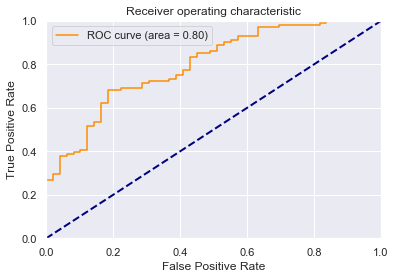

In [21]:
params2={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.005,
    #'gamma':0.01,
    'subsample':0.555,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'max_depth':8,
    #'seed':1024,
    'n_jobs' : -1
}

# xgbclf(params2, X_pp_train, y_pp_train, X_test, y_test)
# xgbclf(params2, X_train_clean, y_train_clean, X_test_clean, y_test_clean)
model = xgbclf(params2, X_train, y_train, X_test, y_test)

In [22]:
model.fit(X_train, y_train,)

[14:54:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.005, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=176, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.555,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

### XGBoost Predictions

In [23]:
model.score(X_test, y_test)

0.76

In [24]:
print(model.score(X_conf_train, y_conf_train))
print(model.score(X_cal, y_cal))

0.7266666666666667
0.7666666666666667


# MACest Confidence Model For The German Credit XGBoost model

Training MACEst model

In [25]:
from macest.classification import models as clmod
from macest.classification import plots as clplot

param_bounds = clmod.SearchBounds(alpha_bounds = (0, 500), k_bounds = (5,15))
neighbour_search_params = clmod.HnswGraphArgs(query_args = dict(ef = 1100))

macest_model = clmod.ModelWithConfidence(model,
                                       X_conf_train,
                                       y_conf_train)

macest_model.fit(X_cal, np.array(y_cal))

Your CPU supports instructions that this binary was not compiled to use: AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


 We can change the MACEst defaults if we want as shown below by editing the NamedTuple for each parameter

In [41]:
clmod.SearchBounds()

SearchBounds(alpha_bounds=(0.1, 100.0), beta_bounds=(0.1, 100.0), k_bounds=(5, 40), temperature_bounds=(0, 40))

In [42]:
clmod.HnswGraphArgs()

HnswGraphArgs(init_args={'method': 'hnsw', 'space': 'l2'}, construction_args={'post': 2, 'efConstruction': 1000, 'M': 100}, query_args={'ef': 1000})

Optimiser args are the arguments passed to scipy differential evolution and must be passed as a dictionary

In [26]:
optimiser_args = dict(popsize = 15)

In [ ]:
# param_bounds = clmod.SearchBounds(k_bounds = (3,50))
# neighbour_search_params = clmod.HnswGraphArgs(query_args = dict(ef = 1100), 
#                                               init_args = dict(method = 'hnsw', space = 'cosinesimil'))

In [27]:
param_bounds = clmod.SearchBounds(k_bounds = (5,50))
neighbour_search_params = clmod.HnswGraphArgs(query_args = dict(ef = 1000))
optimiser_args = dict(popsize = 25, disp = False)

In [45]:
y_cal

452    1
166    0
133    1
735    1
621    0
      ..
284    1
414    0
947    1
11     0
223    1
Name: classification, Length: 150, dtype: int64

In [28]:
macest_model = clmod.ModelWithConfidence(model,
                                      X_conf_train,
                                      y_conf_train, 
                                      search_method_args =neighbour_search_params)

macest_model.fit(X_cal,
               np.array(y_cal),
               param_range = param_bounds,
               optimiser_args = optimiser_args)

In [29]:
macest_model.macest_model_params

MacestConfModelParams(alpha=12.10501354435928, beta=84.71246588588437, num_neighbours=42, temp=1.5655226658443624)

In [30]:
macest_model.__dir__()

['point_pred_model',
 'x_train',
 'y_train',
 'macest_model_params',
 '_num_neighbours',
 '_alpha',
 '_beta',
 '_temp',
 'graph',
 'search_method_args',
 'training_preds_by_class',
 'precomputed_neighbour_info',
 'distance_to_neighbours',
 'index_of_neighbours',
 'error_on_neighbours',
 '_nclasses',
 'point_preds',
 'verbose_training',
 'empirical_conflict_constant',
 '__module__',
 '__doc__',
 '__init__',
 'predict',
 'build_class_graphs',
 'calc_dist_to_neighbours',
 'calc_linear_distance_error_func',
 'predict_proba',
 'predict_confidence_of_point_prediction',
 '_calc_relative_distance_softmax_normalisation',
 '_renormalise_conf_with_empirical_constant',
 'find_conflicting_predictions',
 'fit',
 '_check_consistent_search_method_args',
 '_check_data_consistent_with_search_args',
 '__dict__',
 '__weakref__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce

In [31]:
xgboost_preds = model.predict(X_test)
macest_conf_preds = macest_model.predict_proba(X_test)
xgboost_conf_preds = model.predict_proba(X_test)

In [32]:
xgboost_preds

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0])

In [33]:
xgboost_conf_preds

array([[0.56989896, 0.43010104],
       [0.40961963, 0.5903804 ],
       [0.44365156, 0.55634844],
       [0.31954384, 0.68045616],
       [0.5061359 , 0.49386412],
       [0.4238159 , 0.5761841 ],
       [0.48618054, 0.51381946],
       [0.24832535, 0.75167465],
       [0.41492748, 0.5850725 ],
       [0.320194  , 0.679806  ],
       [0.31247377, 0.6875262 ],
       [0.490511  , 0.509489  ],
       [0.5420867 , 0.45791325],
       [0.44660342, 0.5533966 ],
       [0.4876541 , 0.5123459 ],
       [0.38847995, 0.61152005],
       [0.35785896, 0.64214104],
       [0.51554185, 0.48445815],
       [0.26361507, 0.7363849 ],
       [0.41804063, 0.58195937],
       [0.29554284, 0.70445716],
       [0.25870532, 0.7412947 ],
       [0.39615732, 0.6038427 ],
       [0.27441537, 0.7255846 ],
       [0.55175424, 0.44824573],
       [0.3440054 , 0.6559946 ],
       [0.25795728, 0.7420427 ],
       [0.25747842, 0.7425216 ],
       [0.40757596, 0.59242404],
       [0.5182693 , 0.4817307 ],
       [0.

In [34]:
macest_conf_preds

array([[0.47622607, 0.52377393],
       [0.21085378, 0.78914622],
       [0.16664919, 0.83335081],
       [0.22274167, 0.77725833],
       [0.16979728, 0.83020272],
       [0.22425875, 0.77574125],
       [0.30184046, 0.69815954],
       [0.17697732, 0.82302268],
       [0.17351324, 0.82648676],
       [0.16545029, 0.83454971],
       [0.23094994, 0.76905006],
       [0.51458937, 0.48541063],
       [0.1826426 , 0.8173574 ],
       [0.4331199 , 0.5668801 ],
       [0.30146309, 0.69853691],
       [0.26258969, 0.73741031],
       [0.18023051, 0.81976949],
       [0.23282916, 0.76717084],
       [0.17770922, 0.82229078],
       [0.2045731 , 0.7954269 ],
       [0.26830192, 0.73169808],
       [0.14999738, 0.85000262],
       [0.26150185, 0.73849815],
       [0.17442383, 0.82557617],
       [0.25242801, 0.74757199],
       [0.27141831, 0.72858169],
       [0.179961  , 0.820039  ],
       [0.16111078, 0.83888922],
       [0.22405559, 0.77594441],
       [0.25803528, 0.74196472],
       [0.

In [35]:
macest_point_prediction_conf = macest_model.predict_confidence_of_point_prediction(X_test) 
                              
xgboost_point_prediction_conf = np.amax(xgboost_conf_preds, axis=1)

In [36]:
macest_point_prediction_conf

array([0.47622607, 0.78914622, 0.83335081, 0.77725833, 0.16979728,
       0.77574125, 0.69815954, 0.82302268, 0.82648676, 0.83454971,
       0.76905006, 0.48541063, 0.1826426 , 0.5668801 , 0.69853691,
       0.73741031, 0.81976949, 0.23282916, 0.82229078, 0.7954269 ,
       0.73169808, 0.85000262, 0.73849815, 0.82557617, 0.25242801,
       0.72858169, 0.820039  , 0.83888922, 0.77594441, 0.25803528,
       0.78442237, 0.75059053, 0.78697782, 0.24147985, 0.81961162,
       0.81527138, 0.82517084, 0.70852046, 0.82473619, 0.70181518,
       0.5152268 , 0.1454482 , 0.82963701, 0.15835448, 0.83372251,
       0.23010082, 0.83364438, 0.80444026, 0.8157183 , 0.80914187,
       0.80907431, 0.35217588, 0.73663812, 0.80331146, 0.21389675,
       0.83054587, 0.80164109, 0.73074189, 0.85010952, 0.61651062,
       0.8060719 , 0.77570069, 0.19460499, 0.72763148, 0.26703667,
       0.79157063, 0.77401029, 0.27683989, 0.75127935, 0.79483893,
       0.73995002, 0.80447941, 0.82565602, 0.81021444, 0.70155

In [37]:
xgboost_point_prediction_conf

array([0.56989896, 0.5903804 , 0.55634844, 0.68045616, 0.5061359 ,
       0.5761841 , 0.51381946, 0.75167465, 0.5850725 , 0.679806  ,
       0.6875262 , 0.509489  , 0.5420867 , 0.5533966 , 0.5123459 ,
       0.61152005, 0.64214104, 0.51554185, 0.7363849 , 0.58195937,
       0.70445716, 0.7412947 , 0.6038427 , 0.7255846 , 0.55175424,
       0.6559946 , 0.7420427 , 0.7425216 , 0.59242404, 0.5182693 ,
       0.6020927 , 0.50602925, 0.5017445 , 0.56920624, 0.5932    ,
       0.56100464, 0.7015279 , 0.5060677 , 0.6658587 , 0.5652941 ,
       0.5679723 , 0.5543786 , 0.6630733 , 0.51453984, 0.69289476,
       0.54045236, 0.7538308 , 0.70341736, 0.7102361 , 0.74000067,
       0.5693683 , 0.5845077 , 0.58532536, 0.71910876, 0.59853214,
       0.65299827, 0.5472335 , 0.6326236 , 0.6959179 , 0.5327439 ,
       0.54935867, 0.5381657 , 0.5447667 , 0.65545434, 0.5154872 ,
       0.6938592 , 0.7116199 , 0.53564256, 0.65616214, 0.7418106 ,
       0.667084  , 0.750056  , 0.5829172 , 0.66307175, 0.56754

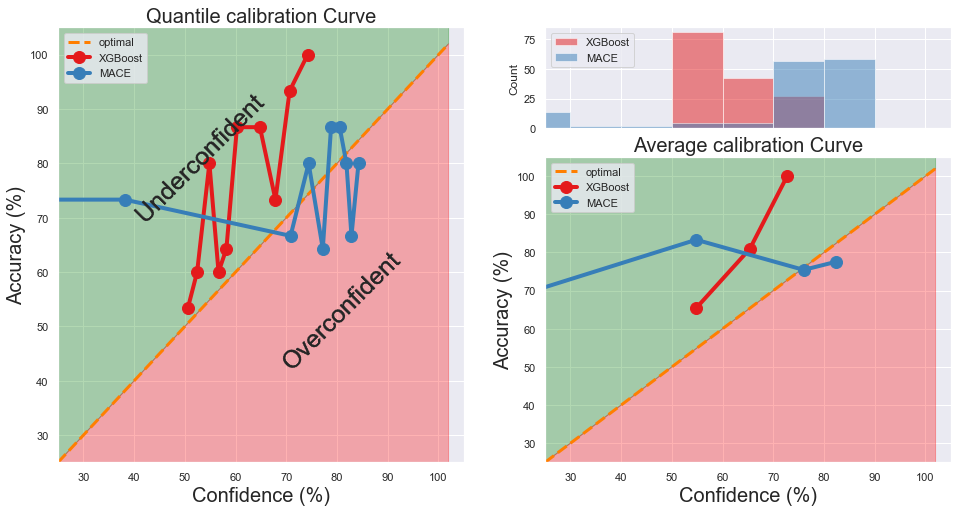

In [38]:
clplot.plot_calibration_curve([xgboost_point_prediction_conf,
                               macest_point_prediction_conf], 
                              ['XGBoost', 'MACE'],
                              xgboost_preds,
                              y_test)

### Let's compare calibration and forecast metrics

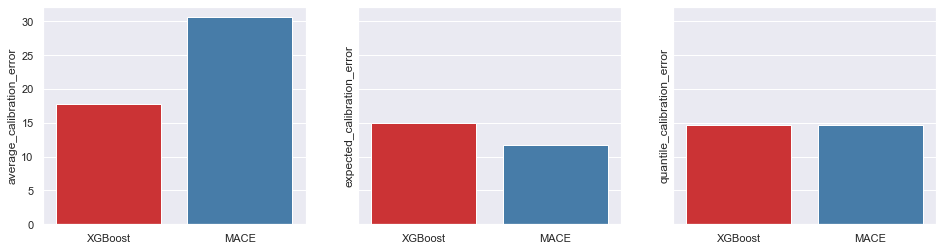

In [39]:
clplot.plot_calibration_metrics([xgboost_point_prediction_conf, 
                                macest_point_prediction_conf], 
                              ['XGBoost','MACE'], xgboost_preds, y_test)

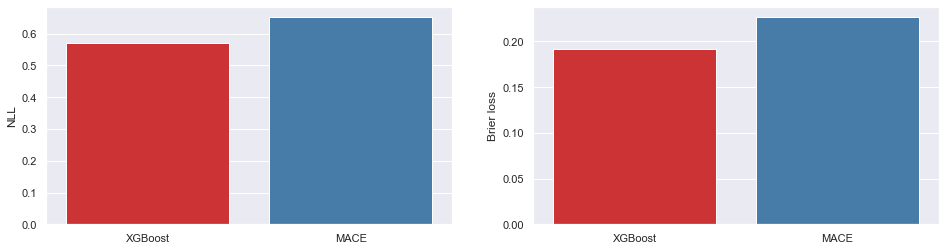

In [40]:
clplot.plot_forecast_metrics([xgboost_point_prediction_conf, 
                                macest_point_prediction_conf], 
                              ['XGBoost','MACE'], xgboost_preds, y_test)

### FPR_FNR